In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import difflib


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
players = pd.read_pickle(os.path.join('Data', 'final_players.pkl')).reset_index(drop = True)
games = pd.read_pickle(os.path.join('Data', 'final_games.pkl')).reset_index(drop = True)

#I saved code people to save time from 1 hr cell below, run this code to see output
#games1 = pd.read_pickle(os.path.join('Data' , 'final_games_pca.pkl'))

In [3]:
players.columns

Index(['SeasonRank', 'Player', 'Team', 'GP', 'MPG', 'FGM', 'FGA', 'FG%', '3PM',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'TOV', 'PF', 'ORB', 'DRB', 'RPG',
       'APG', 'SPG', 'BPG', 'PPG', 'Year'],
      dtype='object')

## PCA TO GET PLAYER RATINGS (OFFENSIVE, DEFENSIVE, AND REBOUNDING)

Now let's do some PCA to reduce dimensions for player averages. I will be performing PCA to get ratings on offence and rebounding. Of course since most of these categories are scaled differently, normalizing to get the most accurate offensive and rebounding score is probably pretty important. For defense, I will not do PCA because there are only two measures for defense, and both are important (I will only do a Standard Scale).
     
PCA loses information however, so I will be making ensuring that a reasonable amount of information isn't lost(meaning explained variance is above a threshhold of at least .60 as recommended in this book: [book_link](amazon.com/Multivariate-Data-Analysis-Joseph-Hair/dp/0138132631). However, I probably still want to keep a lot more information that .60%. In this project, I will be using a threshold of .8

In [4]:
offensive_cols = ['FGM', 'FGA','3PM','3PA','FTM', 'FTA','PPG', 'APG','TOV']

## keeping two components for offence
p1 = Pipeline([('std' ,StandardScaler()), ('pca',PCA(2))])

## PRINTS OUT THE EXPLAINED VARIANCE
proj =p1.fit_transform(players[offensive_cols])
print(p1.named_steps['pca'].explained_variance_ratio_)

#ADDING OFFENSE COMPONENTS TO OG DATA SET
players = pd.concat([players,pd.DataFrame(p1.fit_transform(players[offensive_cols]))], axis = 1)
players = players.rename(columns = {0:'OFFENSIVE_COMP1', 1:'OFFENSIVE_COMP2'})

[0.75136893 0.17531053]


In [5]:
rebounding_cols = ['ORB', 'DRB','RPG']

## keeping one component for rebounding
p2 = Pipeline([('std' ,StandardScaler()), ('pca',PCA(1))])

## PRINTS OUT THE EXPLAINED VARIANCE
proj = p2.fit_transform(players[rebounding_cols])
print(p2.named_steps['pca'].explained_variance_ratio_)

#ADDING REBOUNDING COMPONENTS TO OG DATA SET
players = pd.concat([players,pd.DataFrame(p2.fit_transform(players[rebounding_cols]))], axis = 1)
players = players.rename(columns = {0:'REBOUNDING_COMP1'})

[0.91377225]


In [6]:
defensive_cols = ['SPG','BPG']

## keeping both components for defence
p3 = Pipeline([('std' ,StandardScaler())])

## PRINTS OUT THE EXPLAINED VARIANCE
proj = p3.fit_transform(players[defensive_cols])

players = pd.concat([players,pd.DataFrame(p3.fit_transform(players[defensive_cols]))], axis = 1)
players = players.rename(columns = {0:'DEFENSIVE_COMP1', 1: 'DEFENSIVE_COMP2'})

#### Checking PCA Offensive, Defensive, and Rebounding Components through Warriors Example

Below is how I check my PCA catches enough info. I will be doing this on the Warriors 2019 nba team. Season Rank gives us intuition on how good the player is, so they should deviate. Although they robbed Draymond >:(

In [7]:
## creating the gsw 2019 subplot
gsw_2019 = players[(players['Team'] == 'GSW') & (players['Year'] == 2019)]

gsw_2019.head()

,SeasonRank,Player,Team,GP,MPG,FGM,FGA,FG%,3PM,3PA,...,APG,SPG,BPG,PPG,Year,OFFENSIVE_COMP1,OFFENSIVE_COMP2,REBOUNDING_COMP1,DEFENSIVE_COMP1,DEFENSIVE_COMP2
2481,6,Stephen Curry,GSW,69,33.8,9.2,19.4,0.472,5.1,11.7,...,5.2,1.3,0.4,27.3,2019,11.283529,-3.692065,0.957674,1.574915,0.023073
2484,9,Kevin Durant,GSW,78,34.6,9.2,17.7,0.521,1.8,5.0,...,5.9,0.7,1.1,26.0,2019,6.032409,1.846804,1.394337,0.169846,1.680572
2495,20,Klay Thompson,GSW,78,34.0,8.4,18.0,0.467,3.1,7.7,...,2.4,1.1,0.6,21.5,2019,6.631917,-1.937212,0.037928,1.106559,0.496644
2541,66,DeMarcus Cousins,GSW,30,25.7,5.9,12.4,0.480,0.9,3.2,...,3.6,1.3,1.5,16.3,2019,2.566860,1.514932,2.826534,1.574915,2.627714
2725,250,Draymond Green,GSW,66,31.3,2.8,6.4,0.445,0.7,2.5,...,6.9,1.4,1.1,7.4,2019,1.292474,1.430287,2.126279,1.809094,1.680572


Now lets make sure that the Offensive Components catch enough information by plotting it and checking if stand out players(all stars) actually deviate from the rest of the players. This should be the case because better offensive players should be an outlier from the bench players.

To check this, I will make a scatter plot on the best team in the NBA :) (Totally Not Biased). 

As you can see we do get Klay, Durant and Curry as outliers as expected

Text(0.5, 1.0, 'GSW Offensive PCA PLOT')

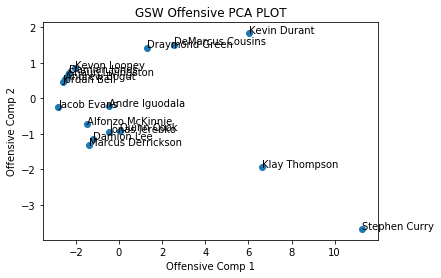

In [8]:
## creating the gsw players corrdinates and names
gsw_players = list(gsw_2019['Player'])
off_comp_1 = list(gsw_2019['OFFENSIVE_COMP1'])
off_comp_2 = list(gsw_2019['OFFENSIVE_COMP2'])

## making the scatterplot
fig, ax = plt.subplots()
ax.scatter(off_comp_1, off_comp_2)

## annottating it
for i, txt in enumerate(gsw_players):
    ax.annotate(txt, (off_comp_1[i], off_comp_2[i]))

## labeling plots
plt.xlabel('Offensive Comp 1')
plt.ylabel('Offensive Comp 2')
plt.title('GSW Offensive PCA PLOT')

For rebounding, we can make sure that PCA captures enought information by checking the best rebounders and making sure that Draymond/ the Centers are the best rebounders. As you can see, that is the case but surprisingly Curry gets rebounds as well.

In [9]:
## displaying the best reboundings on the warriors 2019 team
(gsw_2019[gsw_2019['REBOUNDING_COMP1']
         .isin(gsw_2019['REBOUNDING_COMP1'].nlargest(5))][['Player','REBOUNDING_COMP1']])

,Player,REBOUNDING_COMP1
2481,Stephen Curry,0.957674
2484,Kevin Durant,1.394337
2541,DeMarcus Cousins,2.826534
2725,Draymond Green,2.126279
2778,Kevon Looney,1.533802


Let's do a scatterplot for defensive stats.

We observe that the best defender statistically is Demarcus COusins/ Draymond Green, and it seems that KD and Andre are right up there with him. Surprisingly, Klay isn't as good as a defender as I thought, maybe it's because his defensive skill doesn't show up on the statsheet, but still he is one of the better defenders in GSW.


Text(0.5, 1.0, 'GSW DEFENSIVE PLOT')

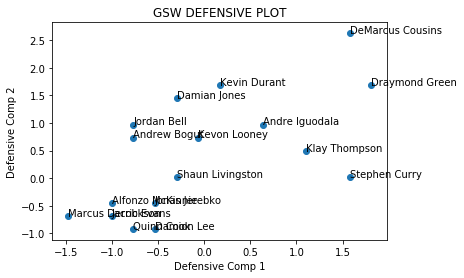

In [10]:
## creating the gsw players corrdinates and names
gsw_players = list(gsw_2019['Player'])
def_comp_1 = list(gsw_2019['DEFENSIVE_COMP1'])
def_comp_2 = list(gsw_2019['DEFENSIVE_COMP2'])

## making the scatterplot
fig, ax = plt.subplots()
ax.scatter(def_comp_1, def_comp_2)

## annottating it
for i, txt in enumerate(gsw_players):
    ax.annotate(txt, (def_comp_1[i], def_comp_2[i]))

## labeling plots
plt.xlabel('Defensive Comp 1')
plt.ylabel('Defensive Comp 2')
plt.title('GSW DEFENSIVE PLOT')

Now that I know PCA captures information correctly, let's get one overall rating for offense and defense for each player. The plan to do this is to change the scale for each component first by using this formula 
(NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin).  This will allow me to scale both components to the same scale. The average of the two components will be the defensive/ offensive score. For rebounding I will only scale.

The scale I will be using is a 0-100 scale


In [11]:
## helper function to get overall ratings (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin)
def get_overall_rating(col_1, col_2):
    ## apply scalar for first and second columns
    ser_1 = players[col_1].apply(lambda x:
                                ((x - (players[col_1].min())) / 
                                 ((players[col_1].max()) - (players[col_1].min()))) 
                                 * (100 - 0) + 0)
    ser_2 = players[col_2].apply(lambda x:
                                ((x - (players[col_2].min())) / 
                                 ((players[col_2].max()) - (players[col_2].min()))) 
                                 * (100 - 0) + 0)
    ## take average
    return (ser_2 + ser_1) / 2

## adds the ratings to the data set
players['OFFENSE_RATING'] = get_overall_rating('OFFENSIVE_COMP1','OFFENSIVE_COMP2')
players['DEFENSE_RATING'] = get_overall_rating('DEFENSIVE_COMP1','DEFENSIVE_COMP2')   
players['REBOUND_RATING'] = players['REBOUNDING_COMP1'].apply(lambda x:((x - (players['REBOUNDING_COMP1'].min()))/ 
                                 ((players['REBOUNDING_COMP1'].max()) - (players['REBOUNDING_COMP1'].min()))) 
                                 * (100 - 0) + 0)

Now let's check our ratings to see if they are reasonable. To do this, I will look at the same wariors data set and I should see scores consistent with what I saw in the scatter plots. Meaning, Klay Thompson, Steph, and Durant should be the higest offensive players and the Hampton 5 should be the best defensive players. As you can see that is the case :)

In [12]:
## making the sub dataset
gsw_2019 = players[(players['Team'] == 'GSW') & (players['Year'] == 2019)]
## displaying the best offensive players on the warriors 2019 team
gsw_2019[gsw_2019['OFFENSE_RATING'].isin(gsw_2019['OFFENSE_RATING'].nlargest(5))][['Player','OFFENSE_RATING']]

,Player,OFFENSE_RATING
2481,Stephen Curry,49.170701
2484,Kevin Durant,60.486989
2495,Klay Thompson,44.251230
2541,DeMarcus Cousins,49.049144
2725,Draymond Green,45.020412


In [13]:
## displaying the best defenders on the warriors 2019 team
gsw_2019[gsw_2019['DEFENSE_RATING'].isin(gsw_2019['DEFENSE_RATING'].nlargest(5))][['Player','DEFENSE_RATING']]

,Player,DEFENSE_RATING
2481,Stephen Curry,31.405405
2484,Kevin Durant,28.864865
2495,Klay Thompson,30.108108
2541,DeMarcus Cousins,46.270270
2725,Draymond Green,42.864865


In [14]:
## displaying the best reboundings on the warriors 2019 team
(gsw_2019[gsw_2019['REBOUND_RATING']
         .isin(gsw_2019['REBOUND_RATING'].nlargest(5))][['Player','REBOUND_RATING']])

,Player,REBOUND_RATING
2481,Stephen Curry,29.891354
2484,Kevin Durant,33.872141
2541,DeMarcus Cousins,46.928621
2725,Draymond Green,40.544820
2778,Kevon Looney,35.143563


In [15]:
players.to_pickle('data/final_players.pkl')

## Merging Components Back to Games 

Now that I have player ratings for offensive,defensive, and rebounding categories for each column per year, I want to add it to my games data set so that I can use it as parameters for modeling. 

Here is the plan:
      - Use games's home_team_players and away_team_players category and the engineered offensive,defensive, and rebounding ratings to get a list of scores across teams. (FOR EACH OF THE YEARS I WILL BE USING LAST YEAR'S RATINGS AS THE COMPONENTS)
      - Then I will take the average of the scores to get an overall team score. However, we have to note that usually teams only play the top 10 players (at max), so for each scoring category I will get rid of outliers by taking the average of the top 10 players.
      
     




### CAUTION THIS CELL WILL TAKE LONG (EST TIME : 1 HRS)

THIS CELL ESSENTIALLY GETS THE COMPONENTS FOR EACH TEAM

In [80]:
## helper function to get home player score per team
def get_scores_helper(col, x, home_or_away):
    lst = []
    for player in x[home_or_away]:
        i = player
        ## if there is inconsistency between name spelling
        if player not in players['Player'].unique():
            i = difflib.get_close_matches(player,players['Player'] , n = 1)
            ## if he's a rookie and we have no stats just skip and append a score of zero
            if len(i) == 0:
                lst.append(0)
                continue
            ## else give it the closest match
            else:
                i = i[0]
        ## get that data frame of scores by the player
        df = players[players['Player'] == i]
        ## you want stats on previous season ideally
        if (x['SEASON'] - 1) in df['Year'].unique():
            score = df[df['Year'] == x['SEASON'] - 1][col].iloc[0]
            lst.append(score)
        ## if u cant get it lets look at stats current season
        elif (x['SEASON']) in df['Year'].unique():
            score = df[df['Year'] == x['SEASON']][col].iloc[0]
            lst.append(score)
        ## if u can't get that we get next closest
        elif (x['SEASON'] + 1 ) in df['Year'].unique():
            score = df[df['Year'] == x['SEASON'] + 1][col].iloc[0]
            lst.append(score)
        ## lets append zero if we cant find a score meaning that person hasent played
        else:
            lst.append(0)
    return lst
## adding home_team_stats
games['OFF_HOME_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('OFFENSE_RATING', x, 'HOME_TEAM_PLAYERS'), axis = 1)
games['DEF_HOME_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('DEFENSE_RATING', x, 'HOME_TEAM_PLAYERS'), axis = 1)
games['REB_HOME_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('REBOUND_RATING', x, 'HOME_TEAM_PLAYERS'), axis = 1)
## adding away_team stats|             
games['OFF_AWAY_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('OFFENSE_RATING', x, 'AWAY_TEAM_PLAYERS'), axis = 1)
games['DEF_AWAY_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('DEFENSE_RATING', x, 'AWAY_TEAM_PLAYERS'), axis = 1)
games['REB_AWAY_TEAM'] = games.apply(lambda x: 
                                             get_scores_helper('REBOUND_RATING', x, 'AWAY_TEAM_PLAYERS'), axis = 1)


Getting rid of outliers and averaging (Step 2) Now I have overall offensive, defensive and reboudding ratings for each team!

In [81]:
## columns to iterate over
player_stats_col = ['OFF_HOME_TEAM', 'DEF_HOME_TEAM', 'REB_HOME_TEAM',
       'OFF_AWAY_TEAM', 'DEF_AWAY_TEAM', 'REB_AWAY_TEAM']
## looping over to get overall scores
for col in player_stats_col:
    games[col[:9] + 'RATING'] = games[col].apply(lambda x: np.mean(pd.Series(sorted(x)).nlargest(10)))

In [82]:
games.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,HOME_TEAM_ABBREV,AWAY_TEAM_ID,AWAY_TEAM_ABBREV,SEASON,HOME_RECORD,ROAD_RECORD,HOME_TEAM_PLAYERS,...,REB_HOME_TEAM,OFF_AWAY_TEAM,DEF_AWAY_TEAM,REB_AWAY_TEAM,OFF_HOME_RATING,DEF_HOME_RATING,REB_HOME_RATING,OFF_AWAY_RATING,DEF_AWAY_RATING,REB_AWAY_RATING
0,2020-03-01,21900895,1610612766,CHA,1610612749,MIL,2019,-10,20,"[Miles Bridges, P.J. Washington, Bismack Biyom...",...,"[23.308831973407106, 31.182094864883947, 35.85...","[35.22876717660929, 65.69235449876932, 37.7094...","[28.05405405405405, 48.91891891891892, 25.5675...","[17.28106695654748, 58.916993867334874, 24.020...",33.477084,20.021622,26.029330,39.084703,26.043243,26.156013
1,2020-03-01,21900896,1610612750,MIN,1610612742,DAL,2019,-15,11,"[Josh Okogie, Juancho Hernangomez, Naz Reid, M...",...,"[17.25898881532161, 13.456670998027207, 24.888...","[41.62244146926659, 29.710952103096684, 48.975...","[24.702702702702705, 12.702702702702702, 48.43...","[22.37412606063427, 21.685969263523607, 38.388...",35.712786,20.486486,23.266696,36.429985,20.762162,21.562970
2,2020-03-01,21900897,1610612746,LAC,1610612755,PHI,2019,19,-13,"[Kawhi Leonard, Marcus Morris Sr., Ivica Zubac...",...,"[26.533392671106416, 30.47002411684483, 18.105...","[25.93974282213501, 42.6812218695769, 44.48622...","[12.000000000000002, 23.405405405405403, 26.86...","[9.964396462598044, 30.33662390755899, 42.5476...",40.421789,25.940541,25.653422,34.188720,22.178378,21.569685
3,2020-03-01,21900898,1610612743,DEN,1610612761,TOR,2019,17,10,"[Will Barton, Jerami Grant, Nikola Jokic, Gary...",...,"[29.068883152536877, 24.15430293073206, 63.988...","[27.52057045795501, 34.03891798056395, 45.9075...","[16.702702702702705, 22.756756756756758, 29.45...","[14.924055357398997, 26.57847134410255, 40.123...",36.647265,22.421622,24.336735,33.382946,19.313514,19.538902
4,2020-03-01,21900899,1610612758,SAC,1610612765,DET,2019,-2,-13,"[Harrison Barnes, Nemanja Bjelica, Harry Giles...",...,"[34.7626909366028, 23.82034569793837, 23.35391...","[27.664451648755787, 32.20682601470979, 37.932...","[17.405405405405407, 12.756756756756758, 30.91...","[10.074796140113614, 23.019953413609556, 41.90...",39.696424,22.264865,25.286163,30.492550,15.410811,17.782184


In [83]:
games.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'HOME_TEAM_ABBREV',
       'AWAY_TEAM_ID', 'AWAY_TEAM_ABBREV', 'SEASON', 'HOME_RECORD',
       'ROAD_RECORD', 'HOME_TEAM_PLAYERS', 'AWAY_TEAM_PLAYERS',
       'HOME_TEAM_WINS', 'OFF_HOME_TEAM', 'DEF_HOME_TEAM', 'REB_HOME_TEAM',
       'OFF_AWAY_TEAM', 'DEF_AWAY_TEAM', 'REB_AWAY_TEAM', 'OFF_HOME_RATING',
       'DEF_HOME_RATING', 'REB_HOME_RATING', 'OFF_AWAY_RATING',
       'DEF_AWAY_RATING', 'REB_AWAY_RATING'],
      dtype='object')

In [84]:
games = games.drop(['HOME_TEAM_ID', 'AWAY_TEAM_ID','GAME_ID','GAME_DATE_EST',
                    'HOME_TEAM_PLAYERS', 'AWAY_TEAM_PLAYERS'], axis = 1)
games[['HOME_TEAM_ABBREV', 'AWAY_TEAM_ABBREV', 'SEASON', 'HOME_RECORD',
       'ROAD_RECORD',]]


,HOME_TEAM_ABBREV,AWAY_TEAM_ABBREV,SEASON,HOME_RECORD,ROAD_RECORD
0,CHA,MIL,2019,-10,20
1,MIN,DAL,2019,-15,11
2,LAC,PHI,2019,19,-13
3,DEN,TOR,2019,17,10
4,SAC,DET,2019,-2,-13
...,...,...,...,...,...
6541,TOR,LAC,2015,1,-1
6542,LAL,UTA,2015,-1,1
6543,ORL,CHA,2015,-1,1
6544,IND,NOP,2015,-1,1


## SAVING PROGRESS

In [85]:
games.to_pickle('data/final_games.pkl')